# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

## 최종 결과값
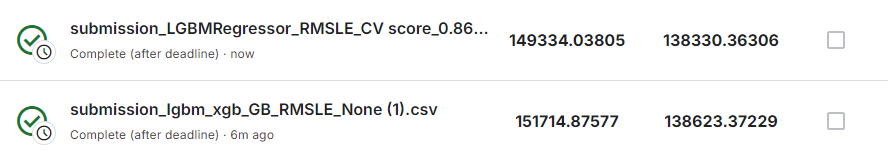
- 처리를 진행했지만 점수가 더 낮아졌다..
- 위의 결과가 LGBM 단독모델 두번째가 3가지를 합친 앙상블 모델이다


# 차례

## EDA
- 상관관계 분석
- 열 제거
- 'date' 처리


## 하이퍼 파라미터 튜닝
#### lgbm 하이퍼 파라미터 튜닝
- learning_rate 추가
- epoch 개선

## 앙상블 모델
### lgbm, xgb, gd 3가지 모델의 결과의 평균값으로 대체
- 단독 모델과 성능 비교


# 회고

진행을 하는 와중에 상관계수는 낮지만 집값에 영향을 많이 미칠것같다는 생각이 드는 인자들이 많이있었다 그런부분에 대해서 차근히 분석해보고싶었지만 4시 50분까지라는 시간제한으로 일단은 결과를 완성했다. 
마찬가지로 하이퍼 파라미터 튜닝도 한가지 모델에 대해서 밖에 진행을 하지못했다. 

아마 시간제한이 없었다면 결과를 보지도않고 계속해서 EDA만 하고있었을 가능성이 높다. 하이퍼파라미터도 계속해서 돌리고있었을거다

성능이 떨어진것에 대해서 생각이 드는 부분은 X 특성에 대해서 로그스케일을 씌운게 오히려 화근이 된걸까
test와 train에 대해서 통계적인 차이가있었을지도 모른다. 

아니면 내가 없앤 column에서 중요한 인자가 있었을지도 모른다


In [1]:
# 사용할 라이브러리
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [2]:
# 라이브러리 버전을 확인한다
import xgboost
import lightgbm
import missingno
import sklearn

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
random_state = 2024

In [50]:
## 데이터를 불러옵니다
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

# trainset과 test셋을 나눕니다
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [51]:
test.shape

(6468, 20)

In [52]:
train.shape

(15035, 21)

## 데이터 전처리 진행

1. 'date' 변환

2. 컬럼 'id' 삭제

3. target값 log변환

In [5]:
# date의 형태를 앞쪽 6글자만 가져오고 정수형으로 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# price부분 target으로 가져오고 열에서 삭제
y = train['price']
del train['price']

# id 열에서 삭제 
del train['id']

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

# y 로그 변환
y = np.log1p(y)

# 하이퍼파라미터 튜닝을 위한 훈련 데이터셋 나눔 
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=0.2,random_state=random_state)

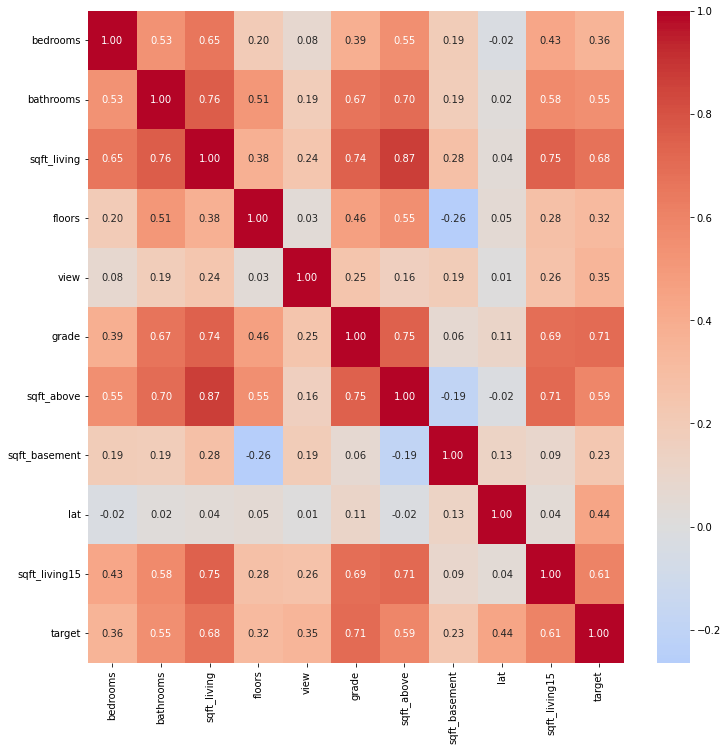

In [6]:
# 데이터 프레임에 price 다시 결합
df_cor_X = train
df_cor_X['target'] = y

# 상관계수 계산
corr = df_cor_X.corr()

# 상관계수중 target에 절대값 적용 
price_correlation = corr['target'].abs()

# 절대값이 0.2이하인 값의 경우만 반환
relevant_columns = price_correlation[price_correlation > 0.2].index
filtered_corr = corr.loc[relevant_columns, relevant_columns]

plt.figure(figsize = (12,12))
sns.heatmap(filtered_corr, fmt='.2f', annot=True, cmap='coolwarm', center=0)
plt.show()

### 상관계수가 0.2보다 낮은 계수들

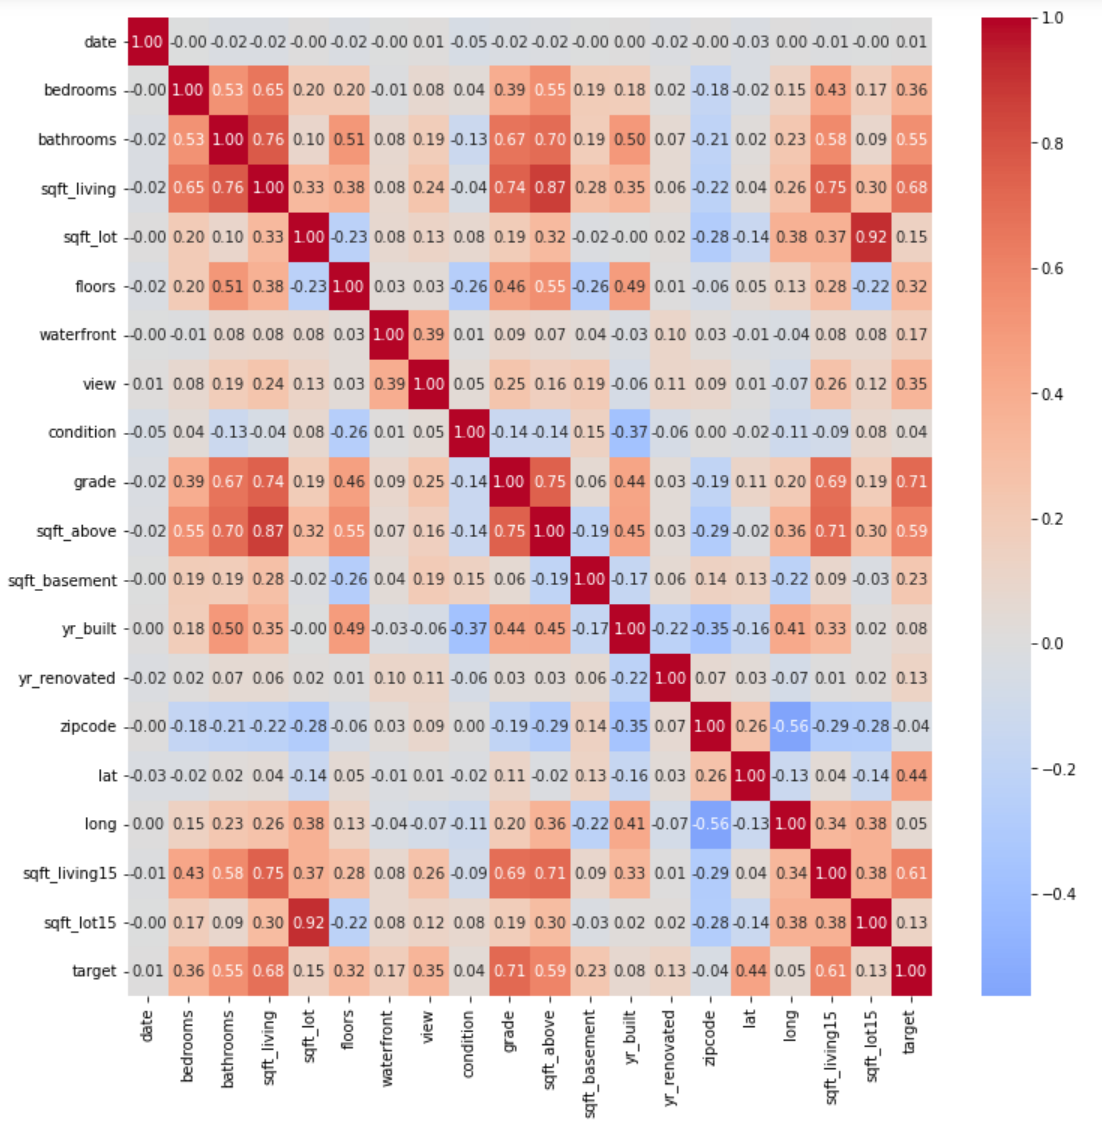

- date
    - 정수 형태 때문에 상관계수가 낮다 월별로 나누는것도 좋아보인다(계절에 따라 다를수있으니)
- sqft_lot
    - 부지의 평방 피트가 중요하지 않다고..? 
- waterfront
    - 리버뷰가 중요하지않다고?
- conditon (0.04?)
    - 집의 전반적인 상태가 어떤 점수형태로 되어있는지를 확인해보자
- yr_bulit (0.08?)
    - 집을 지은 년도도 정수형태로 되어있을것같다. 하지만 이건 숫자 그자체에 영향을 미치잖아
- zipcode ()
    - 우편번호는 뺴자
- long
    - 경도 (왜 위도는 차이가있었을까?)  
    -> 데이터셋의주거지는 시애틀, 그래서 시애틀은 북쪽으로 갈수록 살기 좋은 집들이 많다라고 discussion에 나와있습니다 참고하세유~:)
- sqft_lot15 


### 각 특성 확인

#### conditon 형태 확인
- 3점에 너무 몰려있다.. 이걸 어떻게 전처리 하면좋을까?

#### waterfront 형태 확인
- 0과 1의 불균형이 차이가 많이 난다 의미가 없는 변수일까?

<AxesSubplot:xlabel='condition', ylabel='count'>

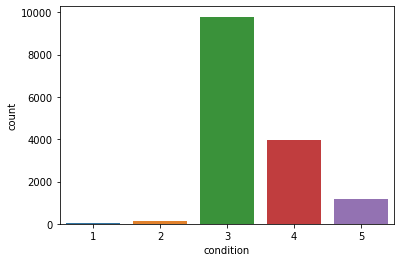

In [7]:
sns.countplot(x = train['condition'], data = train)

<AxesSubplot:xlabel='waterfront', ylabel='count'>

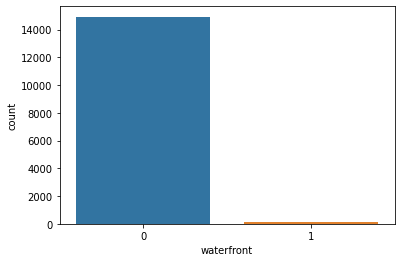

In [8]:
sns.countplot(x = train['waterfront'], data = train)

In [9]:
# 우편번호 제거
del train['zipcode']
# 리버뷰 제거
del train['waterfront']
# 경도 제거
del train['long']
# 컨디션도 제거
del train['condition']

### 계절에 따른 집값의 변화가있을까? 하는 가정을 가지고 date를 전처리해보자


In [10]:
# 월 추출 - 년도는 중요하지않을것같다
train['month'] = train['date'] % 100 

train['Q2'] = train['month'].apply(lambda x: 1 if 4 <= x <= 6 else 0)  # [4, 5, 6]
train['Q3'] = train['month'].apply(lambda x: 1 if 7 <= x <= 9 else 0)  # [7, 8, 9]
train['Q4'] = train['month'].apply(lambda x: 1 if 10 <= x <= 12 else 0)  # [10, 11, 12]
train['Q1'] = train['month'].apply(lambda x: 1 if 1 <= x <= 3 else 0)  # [1, 2, 3]

del train['date']
del train['month']

del train['target']
train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,sqft_living15,sqft_lot15,Q2,Q3,Q4,Q1
0,1.386294,1.00,7.074117,8.639588,1.0,0,7,7.074117,0.0,1955,0,47.5112,7.201171,8.639588,0,0,1,0
1,1.098612,1.00,6.647688,9.210440,1.0,0,6,6.647688,0.0,1933,0,47.7379,7.908755,8.995041,0,0,0,1
2,1.386294,2.00,7.427144,8.997271,1.0,0,8,7.427144,0.0,1987,0,47.6168,7.496097,8.923191,0,0,0,1
3,1.386294,2.25,7.447751,8.827615,2.0,0,7,7.447751,0.0,1995,0,47.3097,7.713785,8.827615,1,0,0,0
4,1.386294,1.50,6.966967,9.181118,1.0,0,7,6.966967,0.0,1963,0,47.4095,7.409136,9.181118,0,0,0,1


### 3 4 5 월에 가장 데이터가 많았다

#### 사실 이것과 집값이 연관이있는지를 알려면 어떤 그래프를 그려야할까?

<BarContainer object of 4 artists>

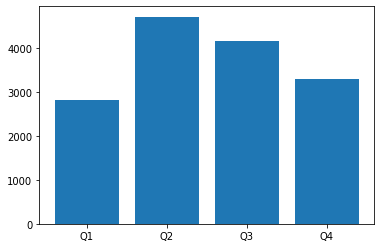

In [39]:
ones_count = train[['Q1','Q2','Q3','Q4']].sum()
plt.bar(ones_count.index, ones_count.values)

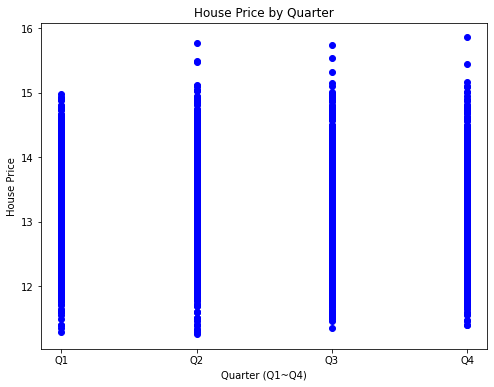

In [43]:
test00 = train.copy()

test00['target'] = y

df_long = pd.melt(test00, id_vars=['target'], value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
                  var_name='Quarter', value_name='Presence')

# 2. Presence 값이 1인 것만 필터링 (즉, 해당 Quarter에 속하는 데이터만 사용)
df_filtered = df_long[df_long['Presence'] == 1]

# 3. 산점도 그리기
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['Quarter'], df_filtered['target'], color='blue')
plt.xlabel('Quarter (Q1~Q4)')
plt.ylabel('House Price')
plt.title('House Price by Quarter')
plt.show()

In [11]:
## test에 전처리 똑같이 진행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
del test['zipcode']
del test['waterfront']
del test['long']
del test['condition']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

test['month'] = test['date'] % 100 

test['Q2'] = test['month'].apply(lambda x: 1 if 4 <= x <= 6 else 0)  # [4, 5, 6]
test['Q3'] = test['month'].apply(lambda x: 1 if 7 <= x <= 9 else 0)  # [7, 8, 9]
test['Q4'] = test['month'].apply(lambda x: 1 if 10 <= x <= 12 else 0)  # [10, 11, 12]
test['Q1'] = test['month'].apply(lambda x: 1 if 1 <= x <= 3 else 0)  # [1, 2, 3]

del test['date']
del test['month']

test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,sqft_living15,sqft_lot15,Q2,Q3,Q4,Q1
0,1.386294,2.25,7.852050,8.887791,2.0,0,7,7.682943,5.993961,1951,1991,47.7210,7.433075,8.941153,0,0,1,0
1,1.609438,3.00,7.581210,8.517393,1.0,0,7,6.957497,6.814543,1965,0,47.5208,7.215975,8.517393,0,0,1,0
2,1.609438,4.50,8.598036,11.532051,1.0,0,11,8.266421,7.333676,2001,0,47.6561,8.468213,11.532051,1,0,0,0
3,1.386294,1.00,7.484930,8.918784,1.0,0,7,6.957497,6.594413,1960,0,47.5123,7.484930,9.001346,1,0,0,0
4,1.386294,2.50,7.544861,8.788898,2.0,0,7,7.544861,0.000000,2003,0,47.3684,7.779467,8.932080,0,0,0,1


### 데이터셋 설명
1. **[제거]** ID : 집을 구분하는 번호
2. **[정수 변환]** date : 집을 구매한 날짜
    - **[원핫 인코딩 진행]** Q1234 로 4개로 나눴다 
3. **[타겟]** price : 타겟 변수인 집의 가격
4. **[로그 변환]** bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. **[로그 변환]** sqft_living : 주거 공간의 평방 피트
7. **[로그 변환]** sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. **[제거]** waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. **[제거]** condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. **[로그 변환]** sqft_above : 지하실을 제외한 평방 피트
14. **[로그 변환]** sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. **[제거]** zipcode : 우편번호
18. lat : 위도
19. **[제거]** long : 경도
20. **[로그 변환]** sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. **[로그 변환]** sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [12]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## GridSearch 함수 준비
- scoring='neg_mean_squared_error'
- verbose = 2
- n_jobs = 5
- cv = 5

In [13]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    # 회귀 모델이기 때문에 'neg_mean_squared_error' 손실함수 사용
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## LGBMRegressor 하이퍼 파라미터 튜닝

### n_estimators = 300
### max_depth = 10
### learning_rate = 0.1 

위 파라미터로 진행

In [14]:
# 파라미터 튜닝할 요소 준비
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1,10],
    'learning_rate' : [0.1,0.5,0.75],
}

model = LGBMRegressor(random_state=random_state)

In [15]:
# model = LGBMRegressor(random_state=random_state)
# my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

## 앙상블 모델 준비



In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(n_estimators = 300, max_depth=10, learning_rate= 0.1, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]



In [17]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [18]:
# 각 모델의 성능 확인
get_cv_score(models)

Model: GradientBoosting, CV score:0.8534
Model: XGBoost, CV score:0.8595
Model: LightGBM, CV score:0.8686


In [21]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [31]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred = np.expm1(y_pred)
y_pred

6468


array([ 548929.28741957,  337135.85187747, 1387818.44879112, ...,
        420247.61309023,  325411.17476552,  418111.26223855])

In [32]:
def save_submission(y_pred, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [33]:
save_submission(y_pred,'lgbm_xgb_GB')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_xgb_GB_RMSLE_None.csv saved!


In [36]:
model = LGBMRegressor(n_estimators = 300, max_depth=10, learning_rate= 0.1, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 530339.27321533,  340720.31828767, 1298717.70928337, ...,
        425501.9109504 ,  303482.78338199,  433895.32728124])

In [37]:
save_submission(prediction,'LGBMRegressor','CV score:0.8686')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_CV score:0.8686.csv saved!


In [49]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission

,id,price
0,15035,5.303393e+05
1,15036,3.407203e+05
2,15037,1.298718e+06
3,15038,3.064263e+05
4,15039,3.048523e+05
...,...,...
6463,21498,2.459239e+05
6464,21499,4.365600e+05
6465,21500,4.255019e+05
6466,21501,3.034828e+05
